# HW4P2: Attention-based Speech Recognition

<img src="https://cdn.shopify.com/s/files/1/0272/2080/3722/products/SmileBumperSticker_5400x.jpg" alt="A cute cat" width="600">


Welcome to the final assignment in 11785. In this HW, you will work on building a speech recognition system with <i>attention</i>. <br> <br>

<center>
<img src="https://popmn.org/wp-content/uploads/2020/03/pay-attention.jpg" alt="A cute cat" height="100">
</center>

HW Writeup: [TODO] <br>
Kaggle Competition Link: https://www.kaggle.com/competitions/11-785-s23-hw4p2/ <br>
Kaggle Dataset Link: https://www.kaggle.com/datasets/varunjain3/11-785-s23-hw4p2-dataset
<br>
LAS Paper: https://arxiv.org/pdf/1508.01211.pdf <br>
Attention is all you need:https://arxiv.org/pdf/1706.03762.pdf

# Read this section importantly!

1. By now, we believe that you are already a great deep learning practitioner, Congratulations. 🎉

2. You are allowed to use code from your previous homeworks for this homework. We will only provide, aspects that are necessary and new with this homework. 

3. There are a lot of resources provided in this notebook, that will help you check if you are running your implementations correctly.

In [ ]:
!nvidia-smi

In [ ]:
# # # Install some required libraries
# # # Feel free to add more if you want
!pip install -q python-levenshtein torchsummaryX wandb kaggle pytorch-nlp 
!pip install wandb --quiet
!pip install python-Levenshtein -q
!git clone --recursive https://github.com/parlance/ctcdecode.git
!pip install wget -q
%cd ctcdecode
!pip install . -q
# %cd ..

!pip install torchsummaryX -q

In [ ]:
# Import Necessary Modules you require for this HW here
import random
import numpy as np
import wandb
import socket

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

import torchsummaryX
from torchsummaryX import summary

import torchaudio.transforms as tat

from sklearn.metrics import accuracy_score
import gc
import glob
import pdb

import zipfile
import pandas as pd
from tqdm import tqdm
import os
import datetime, pytz
import matplotlib.pyplot as plt, seaborn as sns

import Levenshtein

import warnings
warnings.filterwarnings('ignore')

#est = pytz.timezone("America/New_York")
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# root = '11-785-s23-hw3p2' 

print("Device: ", DEVICE)

Device:  cuda


In [ ]:
!wget -q https://cmu.box.com/shared/static/om4qpzd4tf1xo4h7230k4v1pbdyueghe --content-disposition --show-progress
!unzip -q hw4p2_toy.zip -d ./

# Kaggle Dataset Download

In [ ]:
# # To download the dataset
!kaggle datasets download -d varunjain3/11-785-s23-hw4p2-dataset

In [ ]:
 # To unzip data quickly and quietly
!unzip -q 11-785-s23-hw4p2-dataset.zip -d ./data

# Dataset and Dataloaders

In terms of the dataset, the dataset structure for HW3P2 and HW4P2 dataset are very similar. Can you spot out the differences? What all will be required?? 

Hints:

- Check how big is the dataset (do you require memory efficient loading techniques??)
- How do we load mfccs? Do we need to normalise them? 
- Does the data have \<SOS> and \<EOS> tokens in each sequences? Do we remove them or do we not remove them? (Read writeup)
- Would we want a collating function? Ask yourself: Why did we need a collate function last time?
- Observe the VOCAB, is the dataset same as HW3P2? 
- Should you add augmentations, if yes which augmentations? When should you add augmentations? (Check bootcamp for answer)


In [ ]:
# Load the toy dataset
import numpy as np
import torch
X_train = np.load("hw4p2_toy/f0176_mfccs_train_new.npy").astype(np.float32)
X_valid = np.load("hw4p2_toy/f0176_mfccs_dev_new.npy").astype(np.float32)
Y_train = np.load("hw4p2_toy/f0176_hw3p2_train.npy")
Y_valid = np.load("hw4p2_toy/f0176_hw3p2_dev.npy")

# This is how you actually need to find out the different trancripts in a dataset. 
# Can you think whats going on here? Why are we using a np.unique?
VOCAB_MAP_TOY           = dict(zip(np.unique(Y_valid), range(len(np.unique(Y_valid))))) 
VOCAB_MAP_TOY["[PAD]"]  = len(VOCAB_MAP_TOY)
VOCAB_TOY               = list(VOCAB_MAP_TOY.keys())

SOS_TOKEN_TOY = VOCAB_MAP_TOY["[SOS]"]
EOS_TOKEN_TOY = VOCAB_MAP_TOY["[EOS]"]
PAD_TOKEN_TOY = VOCAB_MAP_TOY["[PAD]"]

Y_train = [np.array([VOCAB_MAP_TOY[p] for p in seq]) for seq in Y_train]
Y_valid = [np.array([VOCAB_MAP_TOY[p] for p in seq]) for seq in Y_valid]

In [ ]:
class ToyDataset(torch.utils.data.Dataset):

    def __init__(self, partition):

        if partition == "train":
            self.mfccs = X_train
            self.transcripts = Y_train

        elif partition == "valid":
            self.mfccs = X_valid
            self.transcripts = Y_valid

        assert len(self.mfccs) == len(self.transcripts)

        self.length = len(self.mfccs)

    def __len__(self):

        return self.length

    def __getitem__(self, i):

        x = torch.tensor(self.mfccs[i])
        y = torch.tensor(self.transcripts[i])

        return x, y

    def collate_fn(self, batch):

        x_batch, y_batch = list(zip(*batch))

        x_lens      = [x.shape[0] for x in x_batch] 
        y_lens      = [y.shape[0] for y in y_batch] 

        x_batch_pad = torch.nn.utils.rnn.pad_sequence(x_batch, batch_first=True, padding_value= EOS_TOKEN_TOY)
        y_batch_pad = torch.nn.utils.rnn.pad_sequence(y_batch, batch_first=True, padding_value= EOS_TOKEN_TOY) 
        
        return x_batch_pad, y_batch_pad, torch.tensor(x_lens), torch.tensor(y_lens)

In [ ]:
config = {
  'batch_size': 128,
  'lr':1e-4,
  'epochs': 30,
}
#config['batch_size'] = 128
train_toy_dataset   = ToyDataset(partition= 'train')
valid_toy_dataset   = ToyDataset(partition= 'valid')

train_toy_loader    = torch.utils.data.DataLoader(
    dataset     = train_toy_dataset, 
    batch_size  = config['batch_size'], 
    shuffle     = True,
    num_workers = 4, 
    pin_memory  = True,
    collate_fn  = train_toy_dataset.collate_fn
)

valid_toy_loader    = torch.utils.data.DataLoader(
    dataset     = valid_toy_dataset, 
    batch_size  = config['batch_size'], 
    shuffle     = False,
    num_workers = 2, 
    pin_memory  = True,
    collate_fn  = valid_toy_dataset.collate_fn
)

print("No. of train mfccs   : ", train_toy_dataset.__len__())
print("Batch size           : ", config['batch_size'])
print("Train batches        : ", train_toy_loader.__len__())
print("Valid batches        : ", valid_toy_loader.__len__())

No. of train mfccs   :  16000
Batch size           :  128
Train batches        :  125
Valid batches        :  13


In [ ]:
config = {
  'batch_size':128,
  'lr':1e-3,
  'epochs': 200,
  'listener_input_channel': 27,
  'listener_output_channel': 256,
  'listener_hidden_size': 512,
  'attention_projection_size': 512,
  'speller_hidden_size': 512,
  'speller_embedding_size': 512,
  'lstm_dropout'             : 0.3,
  'encoder_dropout'          : 0.5,
  'speller_dropout'          : 0.3,
  'normal_dropout'           : 0.3,
  'tf_ratio'                 : 1,
  'sc_mode'                  : 'min',
  'sc_factor'                : 0.5,
  'sc_patience'              : 2,
  'sc_threshold'             : 0.5,
  'threshold_mode'           : 'abs',
  }

VOCAB = ['<pad>', '<sos>', '<eos>', 
         'A',   'B',    'C',    'D',    
         'E',   'F',    'G',    'H',    
         'I',   'J',    'K',    'L',       
         'M',   'N',    'O',    'P',    
         'Q',   'R',    'S',    'T', 
         'U',   'V',    'W',    'X', 
         'Y',   'Z',    "'",    ' ', 
         ]

VOCAB_MAP = {VOCAB[i]:i for i in range(0, len(VOCAB))}

PAD_TOKEN = VOCAB_MAP["<pad>"]
SOS_TOKEN = VOCAB_MAP["<sos>"]
EOS_TOKEN = VOCAB_MAP["<eos>"]

print(f"Length of vocab: {len(VOCAB)}")
print(f"Vocab: {VOCAB}")
print(f"PAD_TOKEN: {PAD_TOKEN}")
print(f"SOS_TOKEN: {SOS_TOKEN}")
print(f"EOS_TOKEN: {EOS_TOKEN}")

Length of vocab: 31
Vocab: ['<pad>', '<sos>', '<eos>', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', "'", ' ']
PAD_TOKEN: 0
SOS_TOKEN: 1
EOS_TOKEN: 2


In [ ]:
root = "/content/data"

In [ ]:
import torchaudio
from torchaudio import transforms
def f_mask(data):
    mask = transforms.FrequencyMasking(freq_mask_param=5)
    return mask(data)

def t_mask(data):
    mask = transforms.TimeMasking(time_mask_param=70)
    return mask(data)    

def transforms_data(data):
    data = f_mask(data)
    data = t_mask(data)
    return data

In [ ]:
import torch

class SpeechDataset(torch.utils.data.Dataset):
  
  def __init__(self, root, phonemes, partition= "train-clean-100"):
    self.mfcc_files = sorted(glob(os.path.join(root, partition, "mfcc", "*.npy")))
    self.transcript_files = sorted(glob(os.path.join(root, partition, "transcripts", "*.npy")))

    self.PHONEMES = VOCAB
    self.label_to_int = {label: i for i, label in enumerate(self.PHONEMES)}
    self.features = []
    self.labels = []
    for i, transcript_file in enumerate(self.transcript_files):
            mfcc_file = self.mfcc_files[i]

            assert os.path.splitext(os.path.basename(transcript_file))[0] == os.path.splitext(os.path.basename(mfcc_file))[0]

            mfcc = np.load(mfcc_file)
            transcript = np.load(transcript_file)
            transcript = [self.label_to_int[p] for p in transcript]

            # Normalize the mfcc features
            mfcc -= np.mean(mfcc, axis=0)
            mfcc /= (np.std(mfcc, axis=0) + 1e-8)

            self.features.append(mfcc)
            self.labels.append(transcript)  
  
  def __len__(self):
    return len(self.features)
  
  def __getitem__(self,ind):
    mfcc = torch.tensor(self.features[ind], dtype=torch.float)
    transcript = torch.tensor(self.labels[ind], dtype=torch.long)
       
    return mfcc, transcript
  
  def collate_fn(self,batch):
    #print(batch)
    mfcc, transcript = zip(*batch)
    mfccs_padded = torch.nn.utils.rnn.pad_sequence(mfcc, batch_first=True)
    transcripts_padded = torch.nn.utils.rnn.pad_sequence(transcript, batch_first=True)
    mfcc_lengths = torch.tensor([len(mfcc) for mfcc in mfcc])
    transcript_lengths = torch.tensor([len(transcript) for transcript in transcript])
    return mfccs_padded, transcripts_padded, mfcc_lengths, transcript_lengths

In [ ]:
class SpeechTestDataset(torch.utils.data.Dataset):
  def __init__(self, root, phonemes, partition="test-clean"):
    self.mfcc_files = sorted(glob(os.path.join(root, partition, "mfcc", "*.npy")))
    self.length = len(self.mfcc_files)
    self.PHONEMES = VOCAB
        

        

  def __len__(self):
    return self.length

  def __getitem__(self, idx):
    mfcc_path = self.mfcc_files[idx]
    mfcc = np.load(mfcc_path)
    mfcc -= np.mean(mfcc, axis=0)
    mfcc /= (np.std(mfcc, axis=0) + 1e-8)
    mfcc_tensor = torch.tensor(mfcc, dtype=torch.float)
       
    return mfcc_tensor

  def collate_fn(self, batch):
    mfcc_tensors = [t for t in batch]
    mfccs_padded = torch.nn.utils.rnn.pad_sequence(mfcc_tensors, batch_first=True)
    mfcc_lengths = torch.tensor([len(mfcc) for mfcc in mfcc_tensors])
    return mfccs_padded,  mfcc_lengths

In [ ]:
dev_dataset = SpeechDataset(root, phonemes = VOCAB, partition= "dev-clean")

train_dataset = SpeechDataset(root, phonemes = VOCAB, partition= "train-clean-100")
test_dataset =  SpeechTestDataset(root, phonemes = VOCAB, partition= "test-clean")

dev_loader = torch.utils.data.DataLoader(dev_dataset, num_workers= 2, collate_fn=dev_dataset.collate_fn,
                                           batch_size=BATCH_SIZE, pin_memory= False,
                                           shuffle= False)
train_loader = torch.utils.data.DataLoader(train_dataset, num_workers= 2, collate_fn=train_dataset.collate_fn,
                                           batch_size=BATCH_SIZE, pin_memory= False,
                                           shuffle= True)
test_loader = torch.utils.data.DataLoader(test_dataset, num_workers= 2, collate_fn=test_dataset.collate_fn,
                                           batch_size=BATCH_SIZE, pin_memory= False,
                                           shuffle= False)

print("\nChecking the shapes of the data...")
for batch in dev_loader:
    x, y, lx, ly = batch
    print(x.shape, y.shape, lx.shape, ly.shape)
    break


Checking the shapes of the data...
torch.Size([64, 2936, 27]) torch.Size([64, 364]) torch.Size([64]) torch.Size([64])


Check if you are loading the data correctly with the following:

- Train Dataset
```
Partition loaded:  train-clean-100
Max mfcc length:  2448
Average mfcc length:  1264.6258453344547
Max transcript:  400
Average transcript length:  186.65321139493324
```

- Dev Dataset
```
Partition loaded:  dev-clean
Max mfcc length:  3260
Average mfcc length:  713.3570107288198
Max transcript:  518
Average transcript length:  108.71698113207547
```

- Test Dataset
```
Partition loaded:  test-clean
Max mfcc length:  3491
Average mfcc length:  738.2206106870229
```

If your values is not matching, read hints, think what could have gone wrong. Then approach TAs.

# THE MODEL 

### Listen, Attend and Spell
Listen, Attend and Spell (LAS) is a neural network model used for speech recognition and synthesis tasks.

- LAS is designed to handle long input sequences and is robust to noisy speech signals.
- LAS is known for its high accuracy and ability to improve over time with additional training data.
- It consists of an <b>listener, an attender and a speller</b>, which work together to convert an input speech signal into a corresponding output text.

#### The Dataflow:
<center>
<img src="https://github.com/varunjain3/11785_s23_h4p2/raw/main/DataFlow.png" alt="data flow" height="100">
</center>

#### The Listener: 
- converts the input speech signal into a sequence of hidden states.

#### The Attender:
- Decides how the sequence of Encoder hidden state is propogated to decoder.

#### The Speller:
- A language model, that incorporates the "context of attender"(output of attender) to predict sequence of words.






## The Listener:

Psuedocode:
```python
class Listner:
  def init():
    feature_embedder = #Few layers of 1DConv-batchnorm-activation (Don't overdo)
    pblstm_encoder = #Cascaded pblstm layers (Take pblstm from #HW3P2), 
    #can add more sequential lstms 
    drouput = #As per your liking

  def forward(x,lx):
    embedding = feature_embedder(x) #optional
    encoding, encoding_len = pblstm_encoder(embedding/x,lx)
    #Regularization if needed
    return encoding, encoding_len
```



In [ ]:
# Utils for network
torch.cuda.empty_cache()

class PermuteBlock(torch.nn.Module):

    def forward(self, x):
        return x.transpose(1, 2)

In [ ]:
class pBLSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(pBLSTM, self).__init__()
        self.blstm = torch.nn.LSTM(input_size=input_size*2, hidden_size=hidden_size, num_layers=2, bidirectional=True,batch_first =True)
    
    def forward(self, x_packed):
        #print("In pblstm")

        x, lx = pad_packed_sequence(x_packed, batch_first = True) # Pad the packed sequence to get the padded tensor and the lengths tensor
        #print("Shape of x after pad_packed_sequence:", x.shape)
        #print("Shape of x_lens after pad_packed_sequence:", x_lens.shape)
        
        x, lx = self.trunc_reshape(x, lx) 
        #print("Shape of x after trunc_reshape:", x.shape)
        #print("Shape of x_lens after trunc_reshape:", x_lens.shape)
        
        x_packed = pack_padded_sequence(x, lx, batch_first = True, enforce_sorted=False)
        

        x_packed, _ = self.blstm(x_packed) 

        return x_packed

    def trunc_reshape(self, x, lx):
      batch_size, time_steps, features = x.size()

      if time_steps % 2 != 0: 
        x = x[:, :-1, :] # Remove the last timestep
        time_steps -= 1


      x = x.reshape(batch_size, time_steps // 2, features*2) 
      lx = lx // 2 

      return x, lx

In [ ]:
class LockedDropout(nn.Module):
    def __init__(self, dropout):
        super().__init__()
        self.dropout = dropout

    def forward(self, x):
        if not self.training or not self.dropout:
            return x
        x_unpacked, x_lens = pad_packed_sequence(x, batch_first=True)
        m = x.data.new(1, x_unpacked.size(1), x_unpacked.size(2)).bernoulli_(1 - self.dropout)
        mask = Variable(m, requires_grad=False) / (1 - self.dropout)
        mask = mask.expand_as(x_unpacked)
        out = mask * x_unpacked
        return pack_padded_sequence(out, lengths=x_lens, batch_first=True, enforce_sorted=False)

In [ ]:
class Listener(torch.nn.Module):
  def __init__(self,in_channels , out_channels , encoder_hidden_size):
    super().__init__()

  
    self.in_channels = in_channels
    self.out_channels = out_channels
  
    self.encoder_hid_size = encoder_hidden_size
 
    self.feature_embedder = torch.nn.Sequential(
                        PermuteBlock(),
                        torch.nn.Conv1d(in_channels=self.in_channels, out_channels=self.out_channels, kernel_size=3, stride =1, padding=1),
                        torch.nn.BatchNorm1d(self.out_channels),
                        torch.nn.GELU(),
                        torch.nn.Conv1d(in_channels=self.out_channels, out_channels=self.out_channels, kernel_size=3,stride =1, padding=1),
                        torch.nn.BatchNorm1d(self.out_channels),
                        torch.nn.GELU(),
                        PermuteBlock()
                        ) #convolutions
    self.pblstm_encoder = torch.nn.Sequential(
                        LockedDropout(config['encoder_dropout']),
                        pBLSTM(input_size=self.out_channels, hidden_size=self.encoder_hid_size),
                        LockedDropout(config['encoder_dropout']),
                        pBLSTM(input_size=2*self.encoder_hid_size, hidden_size=self.encoder_hid_size),
                        LockedDropout(config['encoder_dropout']),
                        pBLSTM(input_size=2*self.encoder_hid_size, hidden_size=self.encoder_hid_size//2),
                        )

  def forward(self,x,lx):

    x_em = self.feature_embedder(x.to(DEVICE))
    x_pack = pack_padded_sequence(x_em, lx, batch_first = True, enforce_sorted = False)
    x_pack = self.pblstm_encoder(x_pack)
    encoder_outputs, encoder_lens = pad_packed_sequence(x_pack, batch_first =True)
    
    return encoder_outputs, encoder_lens

    

## Attention

### Different ways to compute Attention

1. Dot-product attention
    * raw_weights = bmm(key, query) 
    * Optional: Scaled dot-product by normalizing with sqrt key dimension 
    * Check "Attention is All You Need" Section 3.2.1
    * 1st way is what most TAs are comfortable with, but if you want to explore, check out other methods below


2. Cosine attention
    * raw_weights = cosine(query, key) # almost the same as dot-product xD 

3. Bi-linear attention
    * W = Linear transformation (learnable parameter): d_k -> d_q
    * raw_weights = bmm(key @ W, query)

4. Multi-layer perceptron
    * Check "Neural Machine Translation and Sequence-to-sequence Models: A Tutorial" Section 8.4

5. Multi-Head Attention
    * Check "Attention is All You Need" Section 3.2.2
    * h = Number of heads
    * W_Q, W_K, W_V: Weight matrix for Q, K, V (h of them in total)
    * W_O: d_v -> d_v
    * Reshape K: (B, T, d_k) to (B, T, h, d_k // h) and transpose to (B, h, T, d_k // h)
    * Reshape V: (B, T, d_v) to (B, T, h, d_v // h) and transpose to (B, h, T, d_v // h)
    * Reshape Q: (B, d_q) to (B, h, d_q // h) `
    * raw_weights = Q @ K^T
    * masked_raw_weights = mask(raw_weights)
    * attention = softmax(masked_raw_weights)
    * multi_head = attention @ V
    * multi_head = multi_head reshaped to (B, d_v)
    * context = multi_head @ W_O


Pseudocode:

```python
class Attention:
    '''
    Attention is calculated using the key, value (from encoder embeddings) and query from decoder.

    After obtaining the raw weights, compute and return attention weights and context as follows.:

    attention_weights   = softmax(raw_weights)
    attention_context   = einsum("thinkwhatwouldbetheequationhere",attention, value) #take hint from raw_weights calculation

    At the end, you can pass context through a linear layer too.
    '''

    def init(listener_hidden_size,
              speller_hidden_size,
              projection_size):

        VW = Linear(listener_hidden_size,projection_size)
        KW = Linear(listener_hidden_size,projection_size)
        QW = Linear(speller_hidden_size,projection_size)

    def set_key_value(encoder_outputs):
        '''
        In this function we take the encoder embeddings and make key and values from it.
        key.shape   = (batch_size, timesteps, projection_size)
        value.shape = (batch_size, timesteps, projection_size)
        '''
        key = KW(encoder_outputs)
        value = VW(encoder_outputs)
      
    def compute_context(decoder_context):
        '''
        In this function from decoder context, we make the query, and then we
         multiply the queries with the keys to find the attention logits, 
         finally we take a softmax to calculate attention energy which gets 
         multiplied to the generted values and then gets summed.

        key.shape   = (batch_size, timesteps, projection_size)
        value.shape = (batch_size, timesteps, projection_size)
        query.shape = (batch_size, projection_size)

        You are also recomended to check out Abu's Lecture 19 to understand Attention better.
        '''
        query = QW(decoder_context) #(batch_size, projection_size)

        raw_weights = #using bmm or einsum. We need to perform batch matrix multiplication. It is important you do this step correctly.
        #What will be the shape of raw_weights?

        attention_weights = #What makes raw_weights -> attention_weights

        attention_context = #Multiply attention weights to values

        return attention_context, attention_weights 
```

In [ ]:

class Attention(torch.nn.Module):
  def __init__(self,listener_hidden_size, speller_hidden_size, projection_size):
    super().__init__()

    self.VW = torch.nn.Linear(listener_hidden_size, projection_size)
    self.KW = torch.nn.Linear(listener_hidden_size, projection_size)
    self.QW = torch.nn.Linear(speller_hidden_size, projection_size)
  
  def set_key_value(self,encoder_outputs):
    
    self.key = self.KW(encoder_outputs)     
    self.value = self.VW(encoder_outputs)  

  def compute_context(self,decoder_context):

    self.query = self.QW(decoder_context) 
    raw_weights = torch.bmm(self.key,self.query.unsqueeze(2)).squeeze(2) 
    attention_weights = torch.softmax(raw_weights,dim=1)
    attention_context = torch.sum(self.value * attention_weights.unsqueeze(2), axis = 1) 

    return attention_context, attention_weights
    

## The Speller

Similar to the language model that you coded up for HW4P1, you have to code a language model for HW4P2 as well. This time, we will also call the attention context step, within the decoder to get the attended-encoder-embeddings.


What you have coded till now:

<center>
<img src="https://github.com/varunjain3/11785_s23_h4p2/raw/main/EncoderAttention.png" alt="data flow" height="400">
</center>

For the Speller, what we have to code:


<center>
<img src="https://github.com/varunjain3/11785_s23_h4p2/raw/main/Decoder.png" alt="data flow" height="400">
</center>

In [ ]:
import torch.nn as nn
from torch.autograd import Variable

class LockedDropoutforSpeller(nn.Module):
    def __init__(self, dropout=0.5):
        super().__init__()
        self.dropout = dropout


    def forward(self, x):
        if not self.training or not self.dropout:
            return x
        m = x.data.new(1, x.size(1)).bernoulli_(1 - self.dropout)
        mask = Variable(m, requires_grad=False) / (1 - self.dropout)
        mask = mask.expand_as(x)
        mask = mask * x
        return mask

In [ ]:
class Speller(torch.nn.Module):

  # Refer to your HW4P1 implementation for help with setting up the language model.
  # The only thing you need to add is the attention module and teacher forcing.

  def __init__(self, attender,max_timestep, vocab_size, embedding_dim, hidden_size):
    super(). __init__()

    self.attend = attender # Attention object in speller
    self.max_timesteps = max_timestep # Max timesteps

    self.vocab_size = vocab_size
    self.embedding_dim = embedding_dim
    self.hidden_size = hidden_size

    self.embedding = torch.nn.Embedding(
            num_embeddings = self.vocab_size,
            embedding_dim = self.embedding_dim).to(DEVICE) # Embedding layer to convert token to latent space
            
    self.lstm_cells =  torch.nn.Sequential(
            torch.nn.LSTMCell(input_size=self.embedding_dim+config['attention_projection_size'], hidden_size=self.hidden_size,bias=True),
            torch.nn.LSTMCell(input_size=self.hidden_size, hidden_size=self.hidden_size,bias=True),
            #torch.nn.LSTMCell(input_size=self.hidden_size, hidden_size=self.hidden_size,bias=True), # TODO: Enter the parameters for the LSTMCells
            )
    
    self.locked_dropout = LockedDropoutforSpeller(config['speller_dropout'])
    
    self.output_to_char = torch.nn.Linear(self.hidden_size+config['attention_projection_size'], self.embedding_dim) #(Optional: TO make dimensions match)
    self.activation = torch.nn.Tanh() # Check which activation is suggested
    self.char_prob = torch.nn.Linear(self.embedding_dim,vocab_size)
    self.char_prob.weight = self.embedding.weight 


  def lstm_step(self, input_word, hidden_state_list):

    for i in range(len(self.lstm_cells)):

      hidden_state_list[i] = self.lstm_cells[i](input_word,hidden_state_list[i])
      input_word = self.locked_dropout(hidden_state_list[i][0])
      
    return input_word, hidden_state_list
    
  def CDN(self,concat_output):
    # Make the CDN here, you can add the output-to-char
    out = self.output_to_char(concat_output)
    out = self.activation(out)
    out = self.char_prob(out)
    return out
    
  def forward (self, batch_size=config['batch_size'], y=None, teacher_forcing_ratio=1, hidden_states_list=None):

    attn_context = torch.zeros((batch_size, config['attention_projection_size'])).to(DEVICE)# initial context tensor
    output_symbol = torch.LongTensor([SOS_TOKEN for _ in range(batch_size)]).to(DEVICE)# Set it to SOS
    raw_outputs = []  
    attention_plot = []
    hidden_states_list = [None]*len(self.lstm_cells) if hidden_states_list == None else hidden_states_list # Initialize your hidden_states list here similar to HW4P1
      
    if y is None:
      timesteps = self.max_timesteps
      teacher_forcing_ratio = 0 #Why does it become zero?

    else:
      timesteps = y.shape[1]# How many timesteps are we predicting for?


    for t in range(timesteps):
      p = np.random.rand()# random function

      if p < teacher_forcing_ratio and t>0 and (y is not None):
        output_symbol = y[:,t-1].to(DEVICE)# Take from y, else draw from probability


      char_embed = self.embedding(output_symbol) # Embed the character symbol

      # Concatenate the character embedding and context from attention
      lstm_input = torch.cat([char_embed, attn_context], dim=-1)
      
      lstm_out, hidden_states_list = self.lstm_step(lstm_input, hidden_states_list) # Feed the input through LSTM Cells and attention.
      # What should we retrieve from forward_step to prepare for the next timestep?

      attn_context, attn_weights = self.attend.compute_context(lstm_out) # Feed the resulting hidden state into attention
    
      cdn_input = torch.cat([lstm_out,attn_context],dim=-1)
     
      raw_pred = self.CDN(cdn_input)# call CDN

      
      output_symbol = torch.argmax(raw_pred,axis=-1)# Draw correctly from raw_pred

      raw_outputs.append(raw_pred) # for loss calculation
      attention_plot.append(attn_weights) # for plottingn attention plot

    
    attention_plot = torch.stack(attention_plot, dim=1)
    raw_outputs = torch.stack(raw_outputs, dim=1)

    return raw_outputs, attention_plot

## LAS

Here we finally build the LAS model, comibining the listener, attender and speller together, we have given a template, but you are free to read the paper and implement it yourself.

In [ ]:
class LAS(torch.nn.Module):
  def __init__(self,in_channels, out_channels, listener_hidden_size, speller_hidden_size, projection_size, max_timestep, vocab_size, speller_embedding_dim): # add parameters
    super().__init__()

    self.listener = Listener(in_channels, out_channels, listener_hidden_size)
    self.attend = Attention(listener_hidden_size, speller_hidden_size, projection_size)
    self.speller = Speller(self.attend, max_timestep, vocab_size, speller_embedding_dim, speller_hidden_size)

  def forward(self,x,lx,y=None,teacher_forcing_ratio=1):
    encoder_outputs, _ = self.listener(x,lx)
    self.attend.set_key_value(encoder_outputs)
    raw_outputs, attention_plots = self.speller(y=y,batch_size=x.shape[0],teacher_forcing_ratio=teacher_forcing_ratio)
    del encoder_outputs
    torch.cuda.empty_cache()
    gc.collect()
    return raw_outputs, attention_plots


# Model Setup 

In [ ]:
# Baseline LAS has the following configuration:
# Encoder bLSTM/pbLSTM Hidden Dimension of 512 (256 per direction)
# Decoder Embedding Layer Dimension of 256
# Decoder Hidden Dimension of 512 
# Attention Projection Size of 128
# Feel Free to Experiment with this 

model = LAS(
    in_channels = config['listener_input_channel'],
    out_channels = config['listener_output_channel'], 
    listener_hidden_size = config['listener_hidden_size'],  
    speller_hidden_size = config['speller_hidden_size'], 
    projection_size = config['attention_projection_size'],  
    max_timestep = 550,
    vocab_size = len(VOCAB), 
    speller_embedding_dim = config['speller_embedding_size'], 
    # Initialize your model 
    # Read the paper and think about what dimensions should be used
    # You can experiment on these as well, but they are not requried for the early submission
    # Remember that if you are using weight tying, some sizes need to be the same
)

for x, y, lx, ly in train_loader:
        print()
        print('x, y, xlens, ylens shapes')
        print(x.shape, y.shape, lx.shape, ly.shape)
        break

model = model.to(DEVICE)


summary(model, 
        x, 
        lx, 
        y)


x, y, xlens, ylens shapes
torch.Size([128, 1621, 27]) torch.Size([128, 328]) torch.Size([128]) torch.Size([128])
                                             Kernel Shape      Output Shape  \
Layer                                                                         
0_listener.feature_embedder.PermuteBlock_0              -   [128, 27, 1621]   
1_listener.feature_embedder.Conv1d_1         [27, 256, 5]  [128, 256, 1621]   
2_listener.feature_embedder.BatchNorm1d_2           [256]  [128, 256, 1621]   
3_listener.feature_embedder.GELU_3                      -  [128, 256, 1621]   
4_listener.feature_embedder.Conv1d_4        [256, 256, 5]  [128, 256, 1621]   
...                                                   ...               ...   
3949_speller.attend.Linear_QW                  [512, 512]        [128, 512]   
3950_speller.attend.Linear_QW                  [512, 512]        [128, 512]   
3951_speller.Linear_output_to_char            [1024, 512]        [128, 512]   
3952_speller.Tanh

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_listener.feature_embedder.PermuteBlock_0,-,"[128, 27, 1621]",NaN,NaN
1_listener.feature_embedder.Conv1d_1,"[27, 256, 5]","[128, 256, 1621]",34816.0,56021760.0
2_listener.feature_embedder.BatchNorm1d_2,[256],"[128, 256, 1621]",512.0,256.0
3_listener.feature_embedder.GELU_3,-,"[128, 256, 1621]",NaN,NaN
4_listener.feature_embedder.Conv1d_4,"[256, 256, 5]","[128, 256, 1621]",327936.0,531169280.0
...,...,...,...,...
3949_speller.attend.Linear_QW,"[512, 512]","[128, 512]",NaN,262144.0
3950_speller.attend.Linear_QW,"[512, 512]","[128, 512]",NaN,262144.0
3951_speller.Linear_output_to_char,"[1024, 512]","[128, 512]",NaN,524288.0


# Loss Function, Optimizers, Scheduler

In [ ]:
optimizer   = torch.optim.AdamW(model.parameters(), lr= config['lr'])
criterion   = torch.nn.CrossEntropyLoss(reduction='mean',ignore_index=PAD_TOKEN) #check how would you fill these values : https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
scaler      = torch.cuda.amp.GradScaler()
scheduler   = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode= config['sc_mode'], factor=config['sc_factor'], patience=config['sc_patience'], threshold=config['sc_threshold'], threshold_mode=config['threshold_mode'],min_lr=1e-6)

# Optional (but Recommended): Create a custom class for a Teacher Force Schedule
class TeacherForcingScheduler():
    def __init__(self, max_rate, min_rate, period, threshold):
        self.max_rate = max_rate
        self.min_rate = min_rate
        self.period = period
        self.threshold = threshold
        self.always_tf = True
        self.step = 0

    def get_rate(self):
        if self.always_tf:
            return self.max_rate
        else:
            step = self.step - self.period // 2
            return (self.max_rate - self.min_rate) / 2 * cos(step * pi/ 
                    self.period) + self.min_rate

    def update(self, ld):
        if not self.always_tf:
            self.step += 1
        else:
            if ld < self.threshold:
                self.always_tf = False
                self.step = 0


teacher_scheduler = TeacherForcingScheduler(1, 0.6, 15, 20)

# Levenshtein Distance

In [ ]:
# We have given you this utility function which takes a sequence of indices and converts them to a list of characters
def indices_to_chars(indices, vocab):
    tokens = []
    for i in indices: # This loops through all the indices
        if int(i) == SOS_TOKEN: # If SOS is encountered, dont add it to the final list
            continue
        elif int(i) == EOS_TOKEN: # If EOS is encountered, stop the decoding process
            break
        else:
            tokens.append(vocab[i])
    return tokens

# To make your life more easier, we have given the Levenshtein distantce / Edit distance calculation code
def calc_edit_distance(predictions, y, ly, vocab= VOCAB, print_example= False):

    dist                = 0
    batch_size, seq_len = predictions.shape

    for batch_idx in range(batch_size): 

        y_sliced    = indices_to_chars(y[batch_idx,0:ly[batch_idx]], vocab)
        pred_sliced = indices_to_chars(predictions[batch_idx], vocab)

        # Strings - When you are using characters from the AudioDataset
        y_string    = ''.join(y_sliced)
        pred_string = ''.join(pred_sliced)
        
        dist        += Levenshtein.distance(pred_string, y_string)
        # Comment the above abd uncomment below for toy dataset 
        # dist      += Levenshtein.distance(y_sliced, pred_sliced)

    if print_example: 
        # Print y_sliced and pred_sliced if you are using the toy dataset
        print("Ground Truth : ", y_string)
        print("Prediction   : ", pred_string)
        
    dist/=batch_size
    return dist

# Train and Validation functions 


In [ ]:
def train(model, dataloader, criterion, optimizer, teacher_forcing_rate):

    model.train()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train')

    running_loss        = 0.0
    running_perplexity  = 0.0
    
    for i, (x, y, lx, ly) in enumerate(dataloader):

        optimizer.zero_grad()

        x, y, lx, ly = x.to(DEVICE), y.to(DEVICE), lx, ly

        with torch.cuda.amp.autocast():

            raw_predictions, attention_plot = model(x, lx, y= y, teacher_forcing_ratio= teacher_forcing_rate)

            # Predictions are of Shape (batch_size, timesteps, vocab_size). 
            # Transcripts are of shape (batch_size, timesteps) Which means that you have batch_size amount of batches with timestep number of tokens.
            # So in total, you have batch_size*timesteps amount of characters.
            # Similarly, in predictions, you have batch_size*timesteps amount of probability distributions.
            # How do you need to modify transcipts and predictions so that you can calculate the CrossEntropyLoss? Hint: Use Reshape/View and read the docs
            # Also feel free to plot the attention plot, you should get convergence in around 10 epochs, if not, there could be something wrong with 
            # your implementation
            pred, timesteps_pred,vocab_size = raw_predictions.shape
            y, timesteps_y = y.shape

            pred_new = raw_predictions.reshape((-1,vocab_size))
            y_new = y.reshape((-1,))

            loss        = criterion(pred_new,y_new) # TODO: Cross Entropy Loss

            perplexity  = torch.exp(loss) # Perplexity is defined the exponential of the loss

            running_loss        += loss.item()
            running_perplexity  += perplexity.item()
        
        # Backward on the masked loss
        scaler.scale(loss).backward()

        # Optional: Use torch.nn.utils.clip_grad_norm to clip gradients to prevent them from exploding, if necessary
        # If using with mixed precision, unscale the Optimizer First before doing gradient clipping
        
        scaler.step(optimizer)
        scaler.update()
        

        batch_bar.set_postfix(
            loss="{:.04f}".format(running_loss/(i+1)),
            perplexity="{:.04f}".format(running_perplexity/(i+1)),
            lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])),
            tf_rate='{:.02f}'.format(teacher_forcing_rate))
        batch_bar.update()

        del x, y, lx, ly
        torch.cuda.empty_cache()

    running_loss /= len(dataloader)
    running_perplexity /= len(dataloader)
    batch_bar.close()

    return running_loss, running_perplexity, attention_plot

In [ ]:
def validate(model, dataloader):

    model.eval()

    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc="Val")

    running_lev_dist = 0.0

    for i, (x, y, lx, ly) in enumerate(dataloader):

        x, y, lx, ly = x.to(DEVICE), y.to(DEVICE), lx, ly

        with torch.inference_mode():
            raw_predictions, attentions = model(x, lx, y = None)

        # Greedy Decoding
        greedy_predictions   =  torch.argmax(raw_predictions, axis=2)# TODO: How do you get the most likely character from each distribution in the batch?

        # Calculate Levenshtein Distance
        running_lev_dist    += calc_edit_distance(greedy_predictions, y, ly, VOCAB, print_example = False) # You can use print_example = True for one specific index i in your batches if you want

        batch_bar.set_postfix(
            dist="{:.04f}".format(running_lev_dist/(i+1)))
        batch_bar.update()

        del x, y, lx, ly
        torch.cuda.empty_cache()

    batch_bar.close()
    running_lev_dist /= len(dataloader)

    return running_lev_dist#, running_loss, running_perplexity, 

# Experiment

In [ ]:
# Login to Wandb
# Initialize your Wandb Run Here
# Save your model architecture in a txt file, and save the file to Wandb
wandb.login(key="a0b5e594abd47863b3c9a38a1319b7dbecb14246")

In [ ]:
run = wandb.init(
    name = "submission1", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "hw4p2-ablations", ### Project should be created in your wandb account 
    config = config ### Wandb Config for your run
)

In [ ]:
def plot_attention(attention): 
    # Function for plotting attention
    # You need to get a diagonal plot
    plt.clf()
    sns.heatmap(attention, cmap='GnBu')
    plt.show()

In [ ]:
def save_model(model, optimizer, scheduler, metric, epoch, path):
    torch.save(
        {'model_state_dict'         : model.state_dict(),
         'optimizer_state_dict'     : optimizer.state_dict(),
         'scheduler_state_dict'     : scheduler.state_dict() if scheduler is not None else {},
         metric[0]                  : metric[1], 
         'epoch'                    : epoch}, 
         path
    )

def load_model(path, model, metric= 'valid_dist', optimizer= None, scheduler= None, load_opt=False, load_sche=False):

    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        
    epoch   = checkpoint['epoch']
    metric  = checkpoint[metric]

    return [model, optimizer, scheduler, epoch, metric]



Epoch: 1/200


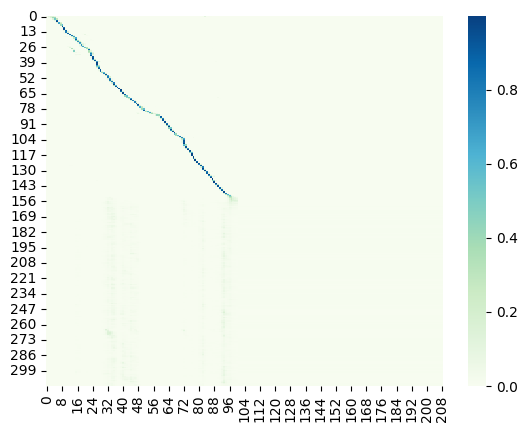

10.767447916666667
Best Valid Dist of 10.7674 at epoch 0

Epoch: 2/200


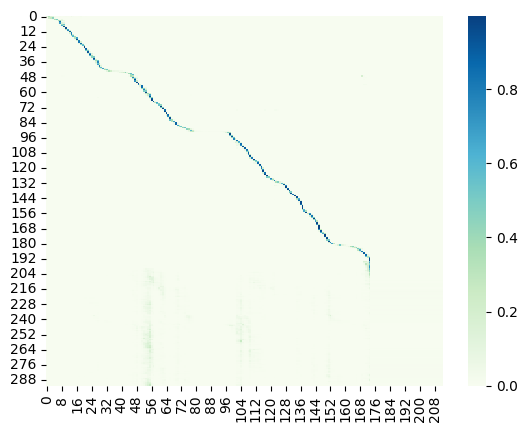

10.894436553030303

Epoch: 3/200


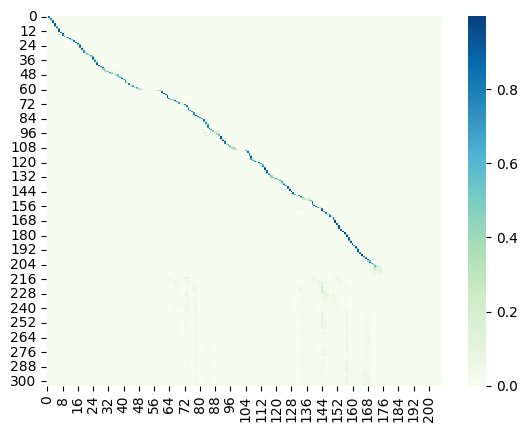

11.131605113636363

Epoch: 4/200


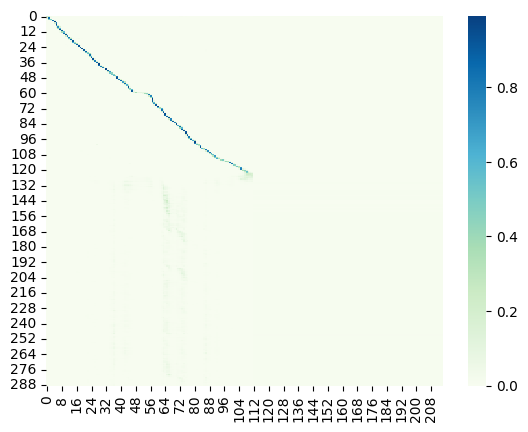

10.905492424242423

Epoch: 5/200


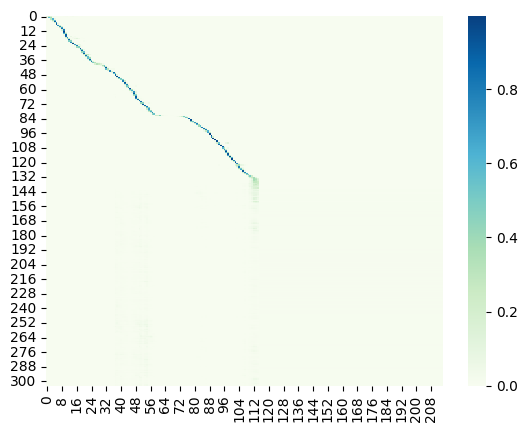

10.420596590909092
Best Valid Dist of 10.4206 at epoch 4

Epoch: 6/200


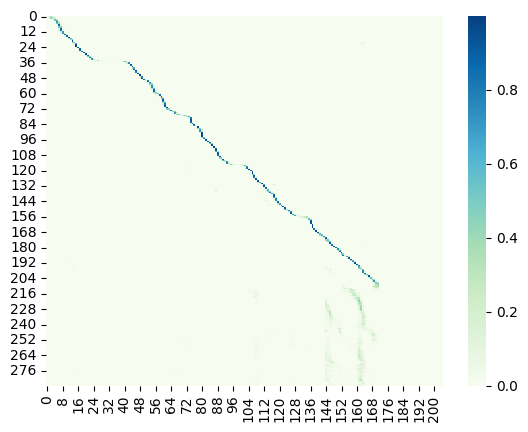

10.99029356060606

Epoch: 7/200


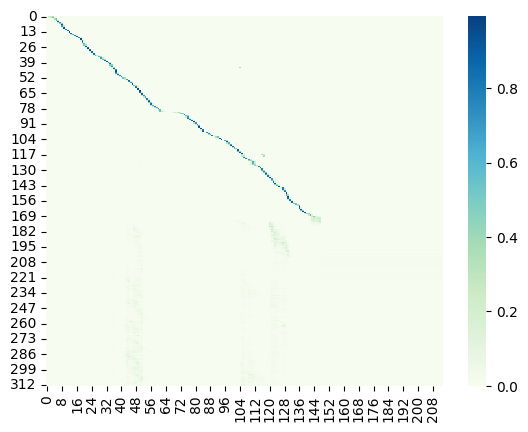

11.174076704545454

Epoch: 8/200


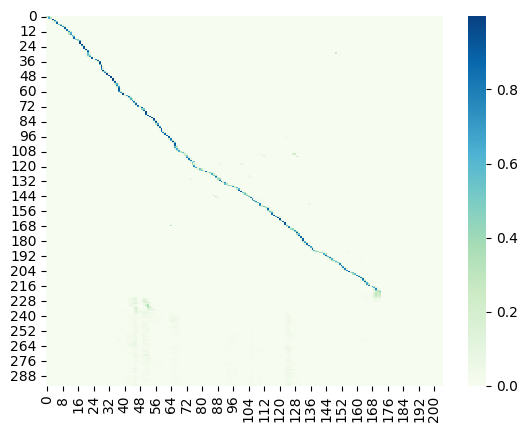

10.316287878787879
Best Valid Dist of 10.3163 at epoch 7

Epoch: 9/200


Train:  89%|████████▉ | 199/223 [08:45<01:03,  2.63s/it, loss=0.1017, lr=0.0000, perplexity=1.1071, tf_rate=0.95]

In [ ]:
best_lev_dist = float("inf")
tf_rate = 1.0
curr_tf_ratio = config['tf_ratio']

for epoch in range(0, config['epochs']):

    torch.cuda.empty_cache()
    gc.collect()
    
    print("\nEpoch: {}/{}".format(epoch+1, config['epochs']))
    curr_lr = float(optimizer.param_groups[0]['lr'])

    # Call train and validate 
    running_loss, running_perplexity, attention_plot =train(model,train_loader,criterion,optimizer,curr_tf_ratio)
    valid_dist = validate(model,dev_loader)
    # Print your metrics
    

    # Plot Attention 
    plot_attention(attention_plot[0].cpu().detach().numpy())

    # Log metrics to Wandb
    wandb.log({
          'running_loss': running_loss,  
          'valid_dist': valid_dist, 
          'tf_ratio': curr_tf_ratio, 
          'lr'        : curr_lr
      })

    # Optional: Scheduler Step / Teacher Force Schedule Step

    scheduler.step(valid_dist)
  
    if epoch > 10: 
      curr_tf_ratio = max(0.99 * curr_tf_ratio, 0.6)

    print(valid_dist)

    #saving checkpoints if model performs better
    if valid_dist <= best_lev_dist:
        best_lev_dist = valid_dist
        print(f'Best Valid Dist of {round(best_lev_dist, 4)} at epoch {epoch}')

        # Save your model checkpoint here
        save_model(model, optimizer, scheduler, ['valid_dist', valid_dist], epoch, f'best_{epoch}.pth')

# Testing

In [ ]:
def indices_to_chars_test(indices):
    tokens = []
    if TOY:
      SOS_TOKEN = SOS_TOKEN_TOY
      EOS_TOKEN = EOS_TOKEN_TOY
    for i in indices: # This loops through all the indices
        if int(i)== SOS_TOKEN: # If SOS is encountered, dont add it to the final list
            continue
        elif int(i) == EOS_TOKEN: # If EOS is encountered, stop the decoding process
            break
        else:
            tokens.append(i)
    return tokens

def test(model, dataloader):

    model.eval()

    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc="Val")

    running_lev_dist = 0.0
    debug_ind = np.random.randint(0,len(dataloader))
    for i, (x, lx) in enumerate(dataloader):
        print(i)

        x, lx = x.to(DEVICE), lx

        with torch.inference_mode():
            predictions, attentions = model(x, lx, y = None)

        beam_results, beam_scores, timesteps, out_seq_len = decoder_test.decode(predictions,seq_lens=lx)

        for i in range(len(beam_results)):
            h_sliced = list(beam_results[i,0][:out_seq_len[i,0]].cpu().numpy())
            h_sliced = indices_to_chars_test(h_sliced)

            h_string = ''.join([itos[c.item()] for c in h_sliced])
            
            preds.append(h_string)

        #print(len(h_string))
        #print(len(preds))
    return preds

In [ ]:
# def test(model, dataloader):

#     model.eval()

#     batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc="Val")

#     running_lev_dist = 0.0

#     predictions = []

#     for i, (x, lx) in enumerate(dataloader):
#         print(i)
#         x, lx = x.to(DEVICE), lx

#         with torch.inference_mode():
#             predictions, attentions = model(x, lx, y = None)


#         # Greedy Decoding
#         greedy_predictions   = torch.argmax(predictions, dim = 2)# How do you get the most likely character from each distribution in the batch?
#         print(greedy_predictions.shape)
#         preds.append(greedy_predictions)
#         print(len(preds))
#         batch_bar.update()

#         del x, lx
#         torch.cuda.empty_cache()

#     batch_bar.close()

#     return preds

In [ ]:
pred_file = test(model, test_loader)

# Create CSV file

In [ ]:
torch.cuda.empty_cache()
predictions = test(model, test_loader)
print(len(predictions))
import pandas as pd

df = pd.read_csv('/content/data/hw4p2/test-clean/transcript/random_submission.csv')
df.label = predictions
df = df.rename(columns={'index':'id'})

df.to_csv('submission.csv', index = False)
!kaggle competitions submit -c 11-785-f22-hw4p2 -f submission.csv -m "Let's Go!"

In [ ]:
# !kaggle competitions submit -c 11-785-s23-hw4p2 -f  -m "Lets Go!"